In [ ]:
!pip install scikit-learn 

Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/ef/0e/97dbca66347b8cf0ea8b529e6bb9367e337ba2e8be0ef5c1a545232abfde/scikit_learn-1.7.2-cp311-cp311-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/1e/e8/685f47e0d754320684db4425a0967f7d3fa70126bffd76110b7009a0090f/joblib-1.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/32/d5/f9a850d79b0851d1d4ef6456097579a9005b31fea68726a4ae5f2d82ddd9/threadpoolctl-3.6.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 58.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 40.7 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
class NeuralNet(torch.nn.Module):
    """
    Implements a neural network representation of
    the Q-function for use in DQN.
    """
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.weights = nn.Sequential(nn.Linear(15,256), 
                                     nn.ReLU(), 
                                     nn.Linear(256, 128), 
                                     nn.ReLU(),
                                     nn.Linear(128, 6)
                                    )

    def forward(self, x):
        """
        Input should represent state/observation space encoding
        Output should be a q-function estimate for each possible
        discrete action.
        """
        return self.weights(x)

In [ ]:
from random import sample
from collections import deque
import copy
import numpy as np
# reused this cell from HW, then made modifications to make it fit the mancala environment
# Check for GPU availability (CUDA first, then MPS, then CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"Using device: {device}")

class MancalaAgent:
    """
    Implements a deep Q-learning agent for the Mancala environment.
    """
    def __init__(self, env, discount=0.99, learning_rate=0.001,
                 buffer_size=100000, batch_size=256, target_update_freq=20000,
                 epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.9999):
        """
        Initialize the DQN agent.
        
        Args:
            discount: Discount factor (gamma)
            learning_rate: Learning rate for optimizer
            buffer_size: Maximum size of replay buffer
            batch_size: Number of transitions to sample per update
            target_update_freq: Steps between target network updates
            epsilon_start: Initial exploration rate
            epsilon_min: Minimum exploration rate
            epsilon_decay: Multiplicative decay for epsilon
        """
        self.env = env
        self.discount = discount
        self.batch_size = batch_size
        self.target_update_freq = target_update_freq
        self.epsilon = epsilon_start
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Initialize replay buffer
        self.replay_buffer = deque(maxlen=buffer_size)
        
        self.network = NeuralNet().to(device)
        self.saved_network = NeuralNet().to(device)
        self.loss = nn.MSELoss()
        self.opt = torch.optim.Adam(self.network.parameters(), lr = learning_rate)
        self.steps = 0
    @torch.no_grad()
    def action_select(self, state):
        """
        Epsilon-greedy action selection using neural network.
        
        Args:
            state: NumPy array of shape (8,)
            
        Returns:
            action: Integer action (0-3)
        """
        # filter to make sure not making illegal moves
        if state[-1] == 1:
            legal_actions = [i for i in range(6) if state[i] > 0]
        else: 
            legal_actions = [i for i in range(6) if state[i+7] > 0]
        
        if len(legal_actions) == 0:
            return self.env.action_space.sample()
        # random action selection
        if np.random.rand() < self.epsilon:
            return np.random.choice(legal_actions)

        # make a choice based on the q-values
        else:
            q_values = self.network(torch.tensor(state, dtype=torch.float).to(device)).cpu().numpy()
            
            masked_q_values = np.full(6, -np.inf)
            masked_q_values[legal_actions] = q_values[legal_actions]
            
            return np.argmax(masked_q_values)



    def update(self, state, action, reward, next_state, terminated):
        """
        Store experience and perform learning update if buffer is ready.
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            terminated: Whether episode terminated
        """
        self.replay_buffer.append((state, action, reward, next_state, terminated))
        self.steps += 1
        if len(self.replay_buffer) < self.batch_size:
            return
        
        self.network.train()  # Ensure network is in training mode
        
        batch = sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        
        states = torch.tensor(np.array(states), dtype=torch.float).to(device)
        actions = torch.tensor(np.array(actions), dtype=torch.long).unsqueeze(1).to(device)
        rewards = torch.tensor(np.array(rewards), dtype=torch.float).unsqueeze(1).to(device)
        next_states = torch.tensor(np.array(next_states), dtype=torch.float).to(device)
        terminations = torch.tensor(np.array(dones), dtype=torch.float).unsqueeze(1).to(device)
        
        with torch.no_grad():
            next_q_values = self.saved_network(next_states).max(1)[0].reshape(-1, 1)
            targets = (rewards + (1 - terminations) * self.discount * next_q_values).clone().detach()
        
        current_q_values = self.network(states)
        predictions = current_q_values.gather(1, actions)
        l = self.loss(predictions, targets)
        l.backward()
        self.opt.step()
        self.opt.zero_grad()
        if self.steps > self.target_update_freq:
            self.saved_network.load_state_dict(self.network.state_dict())
            self.steps = 0
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

Using device: cuda


In [ ]:
# used cursor when writing this class, mainly via a lot of tabbing

class ReinforceAgent:
    """
    Implements a policy-learning agent for the Mancala environment.
    
    """
    def __init__(self, env, discount=0.99, learning_rate=0.00001):
        """
        Initialize the agent.
        
        Args:
            discount: Discount factor (gamma)
            learning_rate: Learning rate for optimizer
        """
        self.env = env
        self.discount = discount
        
        
        self.network = NeuralNet().to(device)
        self.saved_network = NeuralNet().to(device)
        self.opt = torch.optim.Adam(self.network.parameters(), lr = learning_rate)
    # had a first draft, cursor regenrated this in the course of debugging. 
    @torch.no_grad()
    def action_select(self, state):
        """
            selection of an aciton based on the state and policy 
        """
        probs = self.network(torch.tensor(state, dtype=torch.float).to(device))
        # Mask illegal actions
        if state[-1] == 1:
            legal_actions = [i for i in range(6) if state[i] > 0]
        else:
            legal_actions = [i for i in range(6) if state[i+7] > 0]

        if len(legal_actions) == 0:
            return self.env.action_space.sample()
        
        for i in range(6):
            if i not in legal_actions:
                probs[i] = -1e9

        probs = torch.softmax(probs, dim=0).cpu().numpy()
        return np.random.choice(6, p=probs)

    # autogenerate by cursor
    def compute_returns(self, rewards):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + self.discount * R
            returns.append(R)
        return list(reversed(returns))  # Reverse to match original order

    # reused from the previous agent, modified it to work with policy learning 
    def update(self, states, actions, action_mask, returns):
        """
        Store experience and perform learning update if buffer is ready.
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            terminated: Whether episode terminated
        """
        
        self.network.train()  # Ensure network is in training mode
        
        # Convert to tensors with correct shapes
        states_tensor = torch.tensor(np.array(states), dtype=torch.float).to(device)
        actions_tensor = torch.tensor(np.array(actions), dtype=torch.long).to(device)
        returns_tensor = torch.tensor(np.array(returns), dtype=torch.float).to(device)
        action_mask_tensor = torch.tensor(np.array(action_mask), dtype=torch.float).to(device)
        
        # this logic largely implemented by cursor, I wasn't sure about how to convert the mathematical formulas into code and used cursor to help. 
        # Get logits from network
        logits = self.network(states_tensor)
        
        # Apply action mask (illegal actions have -1e9, legal actions have 0)
        masked_logits = logits + action_mask_tensor
        
        # Apply softmax to get probabilities
        probs = torch.softmax(masked_logits, dim=1)
        
        # Get log probabilities for the taken actions
        log_probs = torch.log(probs + 1e-8)  # Add small epsilon for numerical stability
        selected_log_probs = log_probs.gather(1, actions_tensor.unsqueeze(1)).squeeze(1)
        

        loss = -(selected_log_probs * returns_tensor).mean()
        
        # Backpropagate
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()

In [ ]:
import gymnasium as gym
# hit tab a lot when writing this class in Cursor
# used desmos to figure out how sides aligned 
class MancalaEnv(gym.Env):

    # boilerplate code for setting up environment
    # use a single array to track all information about the game state
    def __init__(self):
        self.state = [0]*15
        self.observation_space = gym.spaces.Box(low=0, high=48, shape=(15,), dtype=int)
        self.state[-1] = 1
        self.action_space = gym.spaces.Discrete(6)
        for i in range(6):
            self.state[i] = 4
            self.state[7 + i] = 4

    # print game state in a format that maps to meanings 
    def _get_info(self):
        return {
            "is_player_1_turn": self.state[14],
            "p1_score": self.state[6],
            "p1_pieces": self.state[0:6],
            "p2_score": self.state[13],
            "p2_pieces": self.state[7:13]
        }

    # reset the game state and put stones in the starting positions
    def reset(self, seed = None, options = None):
        super().reset(seed = seed, options = options)
        self.state = [0]*15
        self.state[-1] = 1
        for i in range(6):
            self.state[i] = 4
            self.state[7 + i] = 4
        return self.state, self._get_info()
    
    # take an aciton and update the game state accordingly
    def step(self, action):
        # change turn
        isTerminated = False
        self.state[14] = 1 - self.state[14]

        # if it's player 2's turn, call the p2 step function
        if self.state[14] == 1: 
            return self._step_adversarial(action)
        
        reward = 0
        # if the action is illegal, return a penalty and reset the turn
        if action < 0 or action > 5 or self.state[action] == 0:
            self.state[14] = 1 - self.state[14]
            return self.state, -10, isTerminated, False, self._get_info()
        # set the number of stones to 0 in the chosen pit, then put the stones in the following pits
        stones = self.state[action]
        self.state[action] = 0
        i = action + 1
        for _ in range(stones):
            self.state[i] += 1
            # if the stone is in the store, index reward by 1
            if i == 6: 
                reward += 1
            i += 1
            # if looped around, reset index to 0, skipping the opponent's store
            if i >= 13:
                i = 0
        i -= 1
        # if the last stone was put into the player's store, change the turn back to that player
        if i == 6:
            self.state[14] = 1 - self.state[14]
        # if the last stone was put into a pit with an opponent's stone on the other side, capture the stones into the store. 
        if self.state[12 - i] > 0 and self.state[i] == 1 and i < 6:
            reward += self.state[12 - i] + self.state[i]
            self.state[12 - i] = 0
            self.state[i] = 0
        # if one of the players have no stones left, add the remaining stones on the other side to that player's store and end the game
        # we don't give a reward for having pieices left at the end to add, otherwise the agent tries to optimize too much for having pieces remaining instead of winning. 
        if sum(self.state[0:6]) == 0 or sum(self.state[7:13]) == 0:
            isTerminated = True
            self.state[6] += sum(self.state[0:6])
            self.state[13] += sum(self.state[7:13])
            if self.state[6] > self.state[13]:
                reward += 50 
            elif self.state[13] > self.state[6]:
                reward -= 50  
            # no reward for a tie
        return self.state, reward, isTerminated, False, self._get_info()
    
    # player 2 logic, same as player 1, just with different indices
    # used negative reward for the opponent's moves, because mancala is a zero-sum game, and in training the agent will always be p1. 
    def _step_adversarial(self, action):
        isTerminated = False
        # index the action by 7 to get the correct index for the opppoent's pieces
        action = action + 7
        reward = 0
        if action < 7 or action > 12 or self.state[action] == 0:
            return self.state, -10, isTerminated, False, self._get_info()
        stones = self.state[action]
        self.state[action] = 0
        i = action + 1
        for _ in range(stones):
            self.state[i] += 1
            if i == 13: 
                reward -= 1
            i += 1
            if i >= 14:
                i = 0
        if i == 0:
            self.state[14] = 1 - self.state[14]
        else: 
            i -= 1
            if self.state[i] == 1 and self.state[12 - i] > 0 and i > 6:
                captured = self.state[12 - i] + self.state[i]
                reward -= captured
                self.state[12 - i] = 0
                self.state[i] = 0
        if sum(self.state[0:6]) == 0 or sum(self.state[7:13]) == 0:
            isTerminated = True
            self.state[6] += sum(self.state[0:6])
            self.state[13] += sum(self.state[7:13])
            if self.state[6] > self.state[13]:
                reward += 50 
            elif self.state[13] > self.state[6]:
                reward -= 50
        return self.state, reward, isTerminated, False, self._get_info()


In [ ]:
# boilerplate code for setting up the environment, was used from the gymnasium documentation. 
gym.register(
    id="gymnasium_env/mancala_env-v0",
    entry_point=MancalaEnv,
    max_episode_steps=200
)

/home/users/jsc123/.local/lib/python3.11/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment gymnasium_env/mancala_env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [ ]:
# similar to self-play function, just plays a agent that randomly selects a legal action
# a well-trained agent should be able to consistently beat this agent. 
def play_random(agent, env, n_episodes=1000, print_every=10):
    tot_return = 0
    tot_length = 0
    wins = 0
    count = 0
    for episode in range(n_episodes):
        state, info = env.reset()
        episode_over = False
        if np.random.rand() < .5:
            outcome = env.step(np.random.randint(0, 6))
            state = outcome[0]
            for i in range(7):
                temp = state[i]
                state[i] = state[7+i]
                state[i+7] = temp
        while not episode_over:
            action = agent.action_select(state)
            outcome = env.step(action)
            if outcome[1] >= 25:
                wins += 1
            tot_return += outcome[1]
            episode_over = outcome[2] or outcome[3]
            state = outcome[0]
            while state[-1] == 0 and not episode_over:
                legal_moves = [i for i in range(6) if state[i+7] > 0]
                if len(legal_moves) > 0:
                    action = np.random.choice([i for i in range(6) if state[i+7] > 0])
                else: 
                    action = np.random.randint(0, 6)
                outcome = env.step(action)
                episode_over = outcome[2] or outcome[3]
                state = outcome[0]
                if outcome[1] >= 25:
                    wins += 1
                tot_length += 1
            tot_length += 1
    return wins/n_episodes

In [ ]:
# similar to self-play function, but this one is for two agents to play against each other without training to gauge performance. 
def agent_vs_agent(agent1, agent2, env, n_episodes=1000, print_every=10):
    a1wins = 0
    a2wins = 0
    count = 0
    for episode in range(n_episodes):
        state, info = env.reset()
        episode_over = False
        if np.random.rand() < .5:
            while state[-1] == 1:
                outcome = env.step(agent2.action_select(state))
                state = outcome[0]
            for i in range(7):
                temp = state[i]
                state[i] = state[7+i]
                state[i+7] = temp
            state[-1] = 1
            env.state = state
        while not episode_over:
            action = agent1.action_select(state)
            outcome = env.step(action)
            if outcome[1] >= 25 and episode_over:
                a1wins += 1
            elif outcome[1] <= -25 and episode_over:
                a2wins += 1
            episode_over = outcome[2] or outcome[3]
            state = outcome[0]
            while state[-1] == 0 and not episode_over:
                action = agent2.action_select(state)
                outcome = env.step(action)
                episode_over = outcome[2] or outcome[3]
                state = outcome[0]
                if outcome[1] <= -25 and episode_over:
                    a2wins += 1
                elif outcome[1] >= 25 and episode_over:
                    a1wins += 1

    return a1wins/n_episodes

In [ ]:
import gymnasium as gym 
env = gym.make("gymnasium_env/mancala_env-v0")

suffix = ["short", "medium", "long"]
agents = []
labels = []
for i in suffix:
    agent = MancalaAgent(env, target_update_freq=1000, epsilon_min=.05, learning_rate=.001)
    agent.epsilon = 0
    agent.network.load_state_dict(torch.load(f'deepq_agent_{i}.pth'))
    agents.append(agent)
    labels.append(f'deepq_agent_{i}')
    
    reinforce_agent = ReinforceAgent(env, learning_rate=.001)
    reinforce_agent.network.load_state_dict(torch.load(f'reinforce_agent_{i}.pth'))
    agents.append(reinforce_agent)
    labels.append(f'reinforce_agent_{i}')


In [ ]:
for i in range(6): 
    print(f"Agent {labels[i]} had a winrate against a random agent of {play_random(agents[i], env, n_episodes=1000, print_every=10000)}")

/home/users/jsc123/.local/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:130: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(
/home/users/jsc123/.local/lib/python3.11/site-packages/gymnasium/spaces/box.py:424: UserWarning: WARN: Casting input x to numpy array.
  gym.logger.warn("Casting input x to numpy array.")
/home/users/jsc123/.local/lib/python3.11/site-packages/gymnasium/utils/passive_env_checker.py:130: UserWarning: WARN: The obs returned by the `step()` method was expecting a numpy array, actual type: <class 'list'>
  logger.warn(


Agent deepq_agent_short had a winrate against a random agent of 0.614
Agent reinforce_agent_short had a winrate against a random agent of 0.553
Agent deepq_agent_medium had a winrate against a random agent of 0.692
Agent reinforce_agent_medium had a winrate against a random agent of 0.528
Agent deepq_agent_long had a winrate against a random agent of 0.741
Agent reinforce_agent_long had a winrate against a random agent of 0.776


In [ ]:
winrates = np.zeros((6,6))
count = 0
for i in range(6):
    for j in range(i + 1, 6):
        env.reset()
        winrates[i][j] = agent_vs_agent(agents[i], agents[j], env, n_episodes=1000)
        if i != j:
            winrates[j][i] = 1 - winrates[i][j]
        count += 1
        print(f"{round(100*count/21)}% done")


5% done
10% done
14% done
19% done
24% done
29% done
33% done
38% done
43% done
48% done
52% done
57% done
62% done
67% done
71% done


In [ ]:
print(winrates)

[[0.    0.001 0.    0.    0.528 0.   ]
 [0.999 0.    1.    0.507 0.    0.477]
 [1.    0.    0.    0.996 0.516 1.   ]
 [1.    0.493 0.004 0.    0.    0.002]
 [0.472 1.    0.484 1.    0.    0.472]
 [1.    0.523 0.    0.998 0.528 0.   ]]


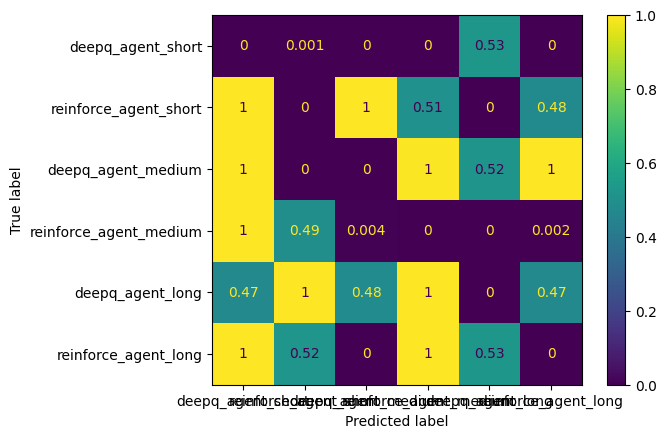

In [ ]:
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=winrates, display_labels=labels)
disp.plot()
plt.show()

In [ ]:
# agent vs agent with print statements for visualization of performance. 
def agent_vs_agent(agent1, agent2, env, n_episodes=1000, print_every=10):
    tot_return = 0
    tot_return_true = 0
    tot_length = 0
    a1wins = 0
    a2wins = 0
    count = 0
    for episode in range(n_episodes):
        state, info = env.reset()
        episode_over = False
        print("Starting State:")
        print(info)
        if np.random.rand() < .5:
            print("agent2 going first")
            while state[-1] == 1:
                outcome = env.step(agent2.action_select(state))
                state = outcome[0]
            for i in range(7):
                temp = state[i]
                state[i] = state[7+i]
                state[i+7] = temp
            state[-1] = 1
            env.state = state
        while not episode_over:
            print("="*50)
            action = agent1.action_select(state)
            print("P1 Turn:")
            print(f"Chosen Action: {action}")
            outcome = env.step(action)
            if outcome[1] >= 25:
                a1wins += 1
            elif outcome[1] <= -25:
                a2wins += 1
            tot_return += outcome[1]
            print(outcome[-1])
            print(state)
            episode_over = outcome[2] or outcome[3]
            state = outcome[0]
            while state[-1] == 0 and not episode_over:
                action = agent2.action_select(state)
                print("P2 Turn:")
                print(f"Action: {action+7}")
                outcome = env.step(action)
                episode_over = outcome[2] or outcome[3]
                state = outcome[0]
                if outcome[1] <= -25:
                    a2wins += 1
                elif outcome[1] >= 25:
                    a1wins += 1
                tot_length += 1
                print(outcome[-1])
                print(state)
            tot_length += 1
    print(f"a1 win% {a1wins/n_episodes}")
    print(f"a2 win% {a2wins/n_episodes}")
agent_vs_agent(agents[5], agents[4], env, n_episodes=2)

Starting State:
{'is_player_1_turn': 1, 'p1_score': 0, 'p1_pieces': [4, 4, 4, 4, 4, 4], 'p2_score': 0, 'p2_pieces': [4, 4, 4, 4, 4, 4]}
agent2 going first
P1 Turn:
Chosen Action: 3
{'is_player_1_turn': 0, 'p1_score': 1, 'p1_pieces': [4, 4, 4, 0, 5, 5], 'p2_score': 0, 'p2_pieces': [5, 0, 5, 5, 5, 5]}
[4, 4, 4, 0, 5, 5, 1, 5, 0, 5, 5, 5, 5, 0, 0]
P2 Turn:
Action: 11
{'is_player_1_turn': 1, 'p1_score': 1, 'p1_pieces': [5, 5, 5, 0, 5, 5], 'p2_score': 1, 'p2_pieces': [5, 0, 5, 5, 0, 6]}
[5, 5, 5, 0, 5, 5, 1, 5, 0, 5, 5, 0, 6, 1, 1]
P1 Turn:
Chosen Action: 0
{'is_player_1_turn': 0, 'p1_score': 1, 'p1_pieces': [0, 6, 6, 1, 6, 6], 'p2_score': 1, 'p2_pieces': [5, 0, 5, 5, 0, 6]}
[0, 6, 6, 1, 6, 6, 1, 5, 0, 5, 5, 0, 6, 1, 0]
P2 Turn:
Action: 10
{'is_player_1_turn': 1, 'p1_score': 1, 'p1_pieces': [1, 7, 6, 1, 6, 6], 'p2_score': 2, 'p2_pieces': [5, 0, 5, 0, 1, 7]}
[1, 7, 6, 1, 6, 6, 1, 5, 0, 5, 0, 1, 7, 2, 1]
P1 Turn:
Chosen Action: 3
{'is_player_1_turn': 0, 'p1_score': 1, 'p1_pieces': [1, 7, 6, 0

In [ ]:
# play_random function with print statements for visualization of performance. 
def play_random(agent, env, n_episodes=1000, print_every=10):
    tot_return = 0
    tot_return_true = 0
    tot_length = 0
    wins = 0
    count = 0
    for episode in range(n_episodes):
        state, info = env.reset()
        episode_over = False
        print("+"*50)
        print("Starting State:")
        print(info)
        if np.random.rand() < .5:
            outcome = env.step(np.random.randint(0, 6))
            state = outcome[0]
            for i in range(7):
                temp = state[i]
                state[i] = state[7+i]
                state[i+7] = temp
            print("Starting State v2:")
            print(outcome[-1])
            state[-1] = 1
            env.state = state
    
        while not episode_over:
            print("="*50)
            action = agent.action_select(state)
            print("P1 Turn:")
            print(f"Chosen Action: {action}")
            outcome = env.step(action)
            if outcome[1] >= 50:
                wins += 1
            tot_return += outcome[1]
            print(f"reward: {outcome[1]}")
            print(outcome[-1])
            print(state)
            episode_over = outcome[2] or outcome[3]
            state = outcome[0]
            while state[-1] == 0 and not episode_over:
                legal_moves = [i for i in range(6) if state[i+7] > 0]
                if len(legal_moves) > 0:
                    action = np.random.choice([i for i in range(6) if state[i+7] > 0])
                else: 
                    action = np.random.randint(0, 6)
                print("P2 Turn:")
                print(f"Action: {action+7}")
                outcome = env.step(action)
                episode_over = outcome[2] or outcome[3]
                state = outcome[0]
                if outcome[1] >= 50:
                    wins += 1
                tot_length += 1
                print(f"reward: {outcome[1]}")
                print(outcome[-1])
                print(state)
            tot_length += 1
    print(wins/n_episodes)

In [ ]:
#REINFORCE agent with long training vs random agent 
play_random(agents[5], env, n_episodes=2)

++++++++++++++++++++++++++++++++++++++++++++++++++
Starting State:
{'is_player_1_turn': 1, 'p1_score': 0, 'p1_pieces': [4, 4, 4, 4, 4, 4], 'p2_score': 0, 'p2_pieces': [4, 4, 4, 4, 4, 4]}
Starting State v2:
{'is_player_1_turn': 0, 'p1_score': 0, 'p1_pieces': [4, 0, 5, 5, 5, 5], 'p2_score': 0, 'p2_pieces': [4, 4, 4, 4, 4, 4]}
P1 Turn:
Chosen Action: 3
reward: 1
{'is_player_1_turn': 0, 'p1_score': 1, 'p1_pieces': [4, 4, 4, 0, 5, 5], 'p2_score': 0, 'p2_pieces': [5, 0, 5, 5, 5, 5]}
[4, 4, 4, 0, 5, 5, 1, 5, 0, 5, 5, 5, 5, 0, 0]
P2 Turn:
Action: 7
reward: 0
{'is_player_1_turn': 1, 'p1_score': 1, 'p1_pieces': [4, 4, 4, 0, 5, 5], 'p2_score': 0, 'p2_pieces': [0, 1, 6, 6, 6, 6]}
[4, 4, 4, 0, 5, 5, 1, 0, 1, 6, 6, 6, 6, 0, 1]
P1 Turn:
Chosen Action: 0
reward: 0
{'is_player_1_turn': 0, 'p1_score': 1, 'p1_pieces': [0, 5, 5, 1, 6, 5], 'p2_score': 0, 'p2_pieces': [0, 1, 6, 6, 6, 6]}
[0, 5, 5, 1, 6, 5, 1, 0, 1, 6, 6, 6, 6, 0, 0]
P2 Turn:
Action: 10
reward: -1
{'is_player_1_turn': 1, 'p1_score': 1, 'p1_p

In [ ]:
#Deep_Q agent with long training vs random agent 
play_random(agents[4], env, n_episodes=2)

++++++++++++++++++++++++++++++++++++++++++++++++++
Starting State:
{'is_player_1_turn': 1, 'p1_score': 0, 'p1_pieces': [4, 4, 4, 4, 4, 4], 'p2_score': 0, 'p2_pieces': [4, 4, 4, 4, 4, 4]}
Starting State v2:
{'is_player_1_turn': 0, 'p1_score': 0, 'p1_pieces': [0, 5, 5, 5, 5, 4], 'p2_score': 0, 'p2_pieces': [4, 4, 4, 4, 4, 4]}
P1 Turn:
Chosen Action: 1
reward: 0
{'is_player_1_turn': 0, 'p1_score': 0, 'p1_pieces': [4, 0, 5, 5, 5, 5], 'p2_score': 0, 'p2_pieces': [0, 5, 5, 5, 5, 4]}
[4, 0, 5, 5, 5, 5, 0, 0, 5, 5, 5, 5, 4, 0, 0]
P2 Turn:
Action: 12
reward: -1
{'is_player_1_turn': 1, 'p1_score': 0, 'p1_pieces': [5, 1, 6, 5, 5, 5], 'p2_score': 1, 'p2_pieces': [0, 5, 5, 5, 5, 0]}
[5, 1, 6, 5, 5, 5, 0, 0, 5, 5, 5, 5, 0, 1, 1]
P1 Turn:
Chosen Action: 3
reward: 1
{'is_player_1_turn': 0, 'p1_score': 1, 'p1_pieces': [5, 1, 6, 0, 6, 6], 'p2_score': 1, 'p2_pieces': [1, 6, 5, 5, 5, 0]}
[5, 1, 6, 0, 6, 6, 1, 1, 6, 5, 5, 5, 0, 1, 0]
P2 Turn:
Action: 9
reward: -1
{'is_player_1_turn': 1, 'p1_score': 1, 'p1_